# Method: Koopman Autoencoders
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:18000]
train.time = train.time[:18000]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (18000, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. Koopman Autoencoder Implementation

In [10]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [11]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [18]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)
    
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [25]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [26]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [27]:
hidden_size = [32, 16, 16, 8]

In [28]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.69 | Train loss = 0.7916090 | Val loss =  0.9811367
Epoch 20: Time taken = 0.79 | Train loss = 0.7454573 | Val loss =  1.0729297
Epoch 30: Time taken = 0.68 | Train loss = 0.7179979 | Val loss =  1.0434494
Epoch 40: Time taken = 0.64 | Train loss = 0.7092747 | Val loss =  1.0198566
Epoch 46: Time taken = 0.69 | Train loss = 0.7021728 | Val loss =  0.9666349
Epoch 50: Time taken = 0.71 | Train loss = 0.6842301 | Val loss =  1.7062993
Best Validation MSE: 0.9666349
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.67 | Train loss = 0.6792590 | Val loss =  1.3471526
Epoch 20: Time taken = 0.82 | Train loss = 0.6770351 | Val loss =  1.2809960
Epoch 30: Time taken = 0.82 | Train loss = 0.6749368 | Val loss =  1.2664141
EARLY STOPPING. Epoch 31: Train loss = 0.6747974 | Val loss =  1.3818698
Best Validation MSE: 1.1553149

Epoch 10: Time taken = 0.71 | Train loss = 0.6785773 | Val loss =  1.3794714
Epoch 20: Time taken = 0.66 | Train loss = 0.6

In [29]:
mean_pred = get_test_pred(X_test, params, network)

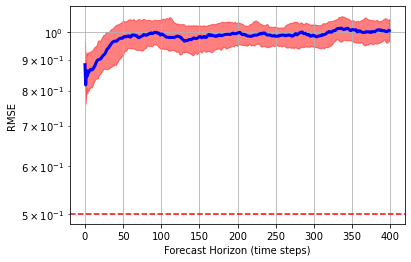

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.902
Median NRMSE at t = 0.5: 0.979
Median NRMSE at t = 1: 0.991
Median NRMSE at t = 2: 0.996
Median NRMSE at t = 3: 0.988


In [30]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 hidden_size = [16, 8, 8, 4]

In [31]:
hidden_size = [16, 8, 8, 4]

In [32]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.70 | Train loss = 0.9161471 | Val loss =  0.9909320
Epoch 20: Time taken = 0.74 | Train loss = 0.8814631 | Val loss =  0.9757650
Epoch 30: Time taken = 0.74 | Train loss = 0.8575034 | Val loss =  1.1284129
Epoch 40: Time taken = 0.67 | Train loss = 0.8532918 | Val loss =  1.1116812
Epoch 50: Time taken = 0.68 | Train loss = 0.8513245 | Val loss =  1.1347378
Best Validation MSE: 0.9489990
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.67 | Train loss = 0.8538042 | Val loss =  1.0414576
Epoch 20: Time taken = 0.68 | Train loss = 0.8514300 | Val loss =  1.1111561
Epoch 30: Time taken = 0.67 | Train loss = 0.8505611 | Val loss =  1.1606234
EARLY STOPPING. Epoch 32: Train loss = 0.8504327 | Val loss =  1.0883953
Best Validation MSE: 1.0390794

Epoch 10: Time taken = 0.67 | Train loss = 0.8523095 | Val loss =  1.1056495
Epoch 20: Time taken = 0.68 | Train loss = 0.8509316 | Val loss =  1.0890514
Epoch 30: Time taken = 0.67 | Train loss = 0.8

In [33]:
mean_pred = get_test_pred(X_test, params, network)

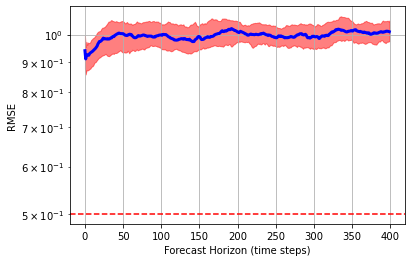

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.973
Median NRMSE at t = 0.5: 1.004
Median NRMSE at t = 1: 0.999
Median NRMSE at t = 2: 1.010
Median NRMSE at t = 3: 0.994


In [34]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 hidden_size = [64, 128, 128, 256]

In [38]:
hidden_size = [64, 128, 128, 256]

In [39]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.41 | Train loss = 0.0399198 | Val loss =  1.6669809
Epoch 20: Time taken = 3.41 | Train loss = 0.0301637 | Val loss =  1.5388782
Epoch 30: Time taken = 3.48 | Train loss = 0.0268653 | Val loss =  2.9422190
Epoch 40: Time taken = 3.37 | Train loss = 0.0244762 | Val loss =  3.1151084
EARLY STOPPING. Epoch 44: Train loss = 0.0236385 | Val loss =  2.8816118
Best Validation MSE: 1.4517167
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.08 | Train loss = 0.0274669 | Val loss =  2.6539491
Epoch 20: Time taken = 2.97 | Train loss = 0.0247914 | Val loss =  2.9084581
Epoch 30: Time taken = 2.99 | Train loss = 0.0226486 | Val loss =  2.8055756
EARLY STOPPING. Epoch 31: Train loss = 0.0224036 | Val loss =  2.7691654
Best Validation MSE: 1.5725493

Epoch 10: Time taken = 3.37 | Train loss = 0.0268458 | Val loss =  2.9284489
Epoch 20: Time taken = 4.13 | Train loss = 0.0242734 | Val loss =  2.9409784
Epoch 30: Time taken = 3.48 | Train loss = 0.02208

In [40]:
mean_pred = get_test_pred(X_test, params, network)

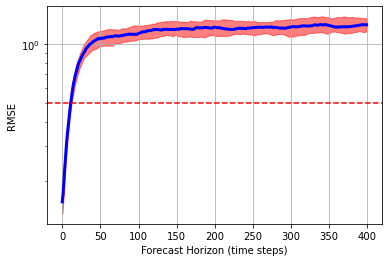

It takes around t = 0.12 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.760
Median NRMSE at t = 0.5: 1.070
Median NRMSE at t = 1: 1.133
Median NRMSE at t = 2: 1.221
Median NRMSE at t = 3: 1.223


In [41]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 hidden_size = [32, 24, 24, 16]

In [44]:
hidden_size = [32, 24, 24, 16]

In [45]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.84 | Train loss = 0.6258273 | Val loss =  1.0556841
Epoch 20: Time taken = 0.70 | Train loss = 0.5635902 | Val loss =  0.9521364
Epoch 30: Time taken = 0.74 | Train loss = 0.5362737 | Val loss =  1.1647569
Epoch 40: Time taken = 0.74 | Train loss = 0.5258357 | Val loss =  0.9700328
Epoch 42: Time taken = 0.72 | Train loss = 0.5248102 | Val loss =  0.9126790
Epoch 50: Time taken = 0.74 | Train loss = 0.5191547 | Val loss =  0.9514604
Best Validation MSE: 0.9126790
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.72 | Train loss = 0.4933855 | Val loss =  1.1953799
Epoch 20: Time taken = 0.73 | Train loss = 0.4800885 | Val loss =  1.0778969
Epoch 30: Time taken = 0.72 | Train loss = 0.4638580 | Val loss =  1.3678342
EARLY STOPPING. Epoch 37: Train loss = 0.4586233 | Val loss =  1.3654773
Best Validation MSE: 0.9109842
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.74 | Train loss = 0.4796720 | Val loss =  1.0556667
Epoch 20: Time taken =

In [46]:
mean_pred = get_test_pred(X_test, params, network)

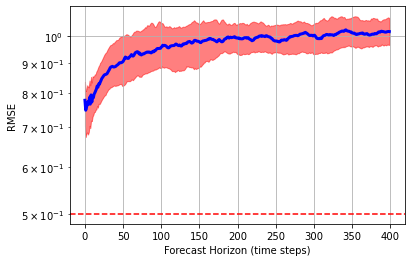

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.835
Median NRMSE at t = 0.5: 0.905
Median NRMSE at t = 1: 0.957
Median NRMSE at t = 2: 0.992
Median NRMSE at t = 3: 1.002


In [47]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 hidden_size = [36, 32, 32, 24]

In [48]:
hidden_size = [36, 32, 32, 24]

In [49]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.75 | Train loss = 0.5179087 | Val loss =  0.9241137
Epoch 20: Time taken = 0.69 | Train loss = 0.4504357 | Val loss =  0.9222535
Epoch 30: Time taken = 0.71 | Train loss = 0.4069252 | Val loss =  0.9331878
Epoch 40: Time taken = 0.80 | Train loss = 0.3806966 | Val loss =  0.9350048
EARLY STOPPING. Epoch 43: Train loss = 0.3701839 | Val loss =  1.1312048
Best Validation MSE: 0.8996241
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.74 | Train loss = 0.4094905 | Val loss =  0.9531953
Epoch 20: Time taken = 0.76 | Train loss = 0.3838831 | Val loss =  0.9274847
Epoch 30: Time taken = 0.71 | Train loss = 0.3643143 | Val loss =  1.0783225
Epoch 40: Time taken = 0.72 | Train loss = 0.3593536 | Val loss =  1.2572163
Epoch 50: Time taken = 0.70 | Train loss = 0.3533799 | Val loss =  1.0942409
Best Validation MSE: 0.9062143

Epoch 10: Time taken = 0.73 | Train loss = 0.3604663 | Val loss =  1.0838917
Epoch 20: Time taken = 0.72 | Train loss = 0.3

In [50]:
mean_pred = get_test_pred(X_test, params, network)

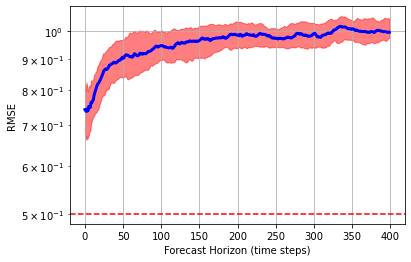

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.831
Median NRMSE at t = 0.5: 0.903
Median NRMSE at t = 1: 0.947
Median NRMSE at t = 2: 0.985
Median NRMSE at t = 3: 0.991


In [51]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.6 hidden_size = [40, 40, 40, 40]

In [35]:
hidden_size = [40, 40, 40, 40]

In [36]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.85 | Train loss = 0.3975960 | Val loss =  0.9769918
Epoch 20: Time taken = 0.91 | Train loss = 0.3258320 | Val loss =  0.9473956
Epoch 30: Time taken = 0.85 | Train loss = 0.2916495 | Val loss =  0.9783209
EARLY STOPPING. Epoch 38: Train loss = 0.2573719 | Val loss =  0.9591689
Best Validation MSE: 0.8979720
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.84 | Train loss = 0.3142212 | Val loss =  0.9479392
Epoch 20: Time taken = 0.88 | Train loss = 0.2652478 | Val loss =  1.1103877
Epoch 30: Time taken = 0.92 | Train loss = 0.2461218 | Val loss =  1.0171653
EARLY STOPPING. Epoch 38: Train loss = 0.2395585 | Val loss =  1.0462644
Best Validation MSE: 0.9125509

Epoch 10: Time taken = 0.91 | Train loss = 0.2567701 | Val loss =  1.0118234
Epoch 20: Time taken = 0.86 | Train loss = 0.2430318 | Val loss =  1.0764773
Epoch 30: Time taken = 0.86 | Train loss = 0.2290478 | Val loss =  1.1618527
EARLY STOPPING. Epoch 35: Train loss = 0.2221650 |

In [37]:
mean_pred = get_test_pred(X_test, params, network)

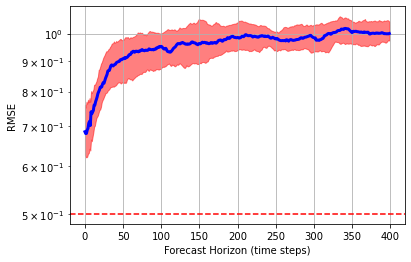

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.814
Median NRMSE at t = 0.5: 0.908
Median NRMSE at t = 1: 0.952
Median NRMSE at t = 2: 0.985
Median NRMSE at t = 3: 0.984


In [38]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 max_lag

In [46]:
loss_weights = [1, 1, .1, .01]
hidden_size = [64, 128, 128, 256]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.2.1 max_lag = 4

In [47]:
max_lag = 4

In [48]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.24 | Train loss = 0.0215190 | Val loss =  2.1199685
Epoch 20: Time taken = 3.31 | Train loss = 0.0134661 | Val loss =  2.4100508
Epoch 30: Time taken = 4.23 | Train loss = 0.0108850 | Val loss =  2.8009532
EARLY STOPPING. Epoch 31: Train loss = 0.0107158 | Val loss =  2.8080578
Best Validation MSE: 1.5989510
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.76 | Train loss = 0.0166352 | Val loss =  2.1321006
Epoch 20: Time taken = 3.17 | Train loss = 0.0117775 | Val loss =  2.6093123
Epoch 30: Time taken = 3.18 | Train loss = 0.0100086 | Val loss =  3.2588417
EARLY STOPPING. Epoch 31: Train loss = 0.0098607 | Val loss =  3.2304407
Best Validation MSE: 1.8120635

Epoch 10: Time taken = 3.19 | Train loss = 0.0142061 | Val loss =  2.2135226
Epoch 20: Time taken = 3.22 | Train loss = 0.0108683 | Val loss =  2.7226710
Epoch 30: Time taken = 3.28 | Train loss = 0.0095027 | Val loss =  3.4777424
EARLY STOPPING. Epoch 31: Train loss = 0.0094079 |

In [49]:
mean_pred = get_test_pred(X_test, params, network)

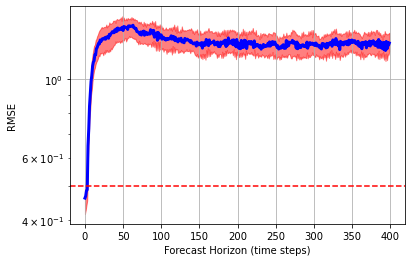

It takes around t = 0.04 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 1.290
Median NRMSE at t = 0.5: 1.372
Median NRMSE at t = 1: 1.333
Median NRMSE at t = 2: 1.233
Median NRMSE at t = 3: 1.255


In [50]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 max_lag = 8
This is already done in 3.1.6

### 3.2.3 max_lag = 16

In [16]:
max_lag = 16

In [17]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.86 | Train loss = 0.1055726 | Val loss =  1.0527659
Epoch 20: Time taken = 3.73 | Train loss = 0.0809304 | Val loss =  1.1238262
Epoch 30: Time taken = 3.79 | Train loss = 0.0718750 | Val loss =  2.0671026
EARLY STOPPING. Epoch 34: Train loss = 0.0682107 | Val loss =  2.1570676
Best Validation MSE: 0.9868232
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.76 | Train loss = 0.0840482 | Val loss =  1.0892373
Epoch 20: Time taken = 3.76 | Train loss = 0.0737236 | Val loss =  2.1909799
Epoch 30: Time taken = 3.76 | Train loss = 0.0637078 | Val loss =  2.0683847
EARLY STOPPING. Epoch 33: Train loss = 0.0606385 | Val loss =  2.2195903
Best Validation MSE: 0.9791381
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.73 | Train loss = 0.0783075 | Val loss =  1.3423347
Epoch 20: Time taken = 3.20 | Train loss = 0.0685677 | Val loss =  2.1334650
Epoch 30: Time taken = 3.19 | Train loss = 0.0577020 | Val loss =  2.1474791
EARLY STOPPING. Epoch 32: 

In [18]:
mean_pred = get_test_pred(X_test, params, network)

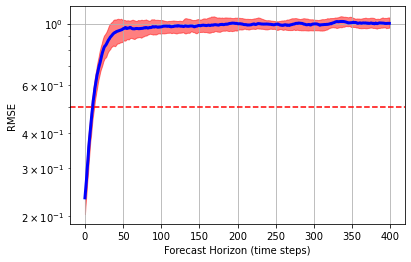

It takes around t = 0.11 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.725
Median NRMSE at t = 0.5: 0.958
Median NRMSE at t = 1: 0.973
Median NRMSE at t = 2: 1.000
Median NRMSE at t = 3: 0.997


In [19]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 max_lag = 24

In [43]:
max_lag = 24

In [44]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.84 | Train loss = 0.1775116 | Val loss =  1.0018090
Epoch 20: Time taken = 3.76 | Train loss = 0.1419359 | Val loss =  1.1225580
Epoch 30: Time taken = 3.68 | Train loss = 0.1164033 | Val loss =  1.9709130
EARLY STOPPING. Epoch 34: Train loss = 0.1060455 | Val loss =  1.8661936
Best Validation MSE: 0.9889071
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.84 | Train loss = 0.1497182 | Val loss =  1.0178310
Epoch 20: Time taken = 3.77 | Train loss = 0.1239972 | Val loss =  2.0690312
Epoch 30: Time taken = 3.72 | Train loss = 0.0989628 | Val loss =  2.0261836
EARLY STOPPING. Epoch 33: Train loss = 0.0929586 | Val loss =  2.1085317
Best Validation MSE: 0.9849930
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.59 | Train loss = 0.1369220 | Val loss =  1.2025533
Epoch 20: Time taken = 3.51 | Train loss = 0.1102279 | Val loss =  1.7559420
Epoch 30: Time taken = 3.63 | Train loss = 0.0885375 | Val loss =  2.0745835
EARLY STOPPING. Epoch 32: 

In [45]:
mean_pred = get_test_pred(X_test, params, network)

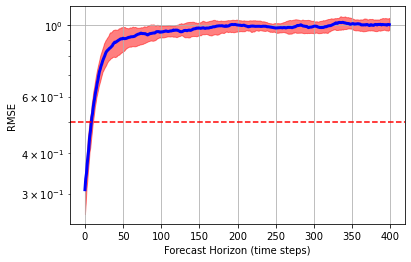

It takes around t = 0.09 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.730
Median NRMSE at t = 0.5: 0.912
Median NRMSE at t = 1: 0.954
Median NRMSE at t = 2: 1.002
Median NRMSE at t = 3: 0.993


In [46]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 max_lag = 32

In [57]:
max_lag = 32

In [58]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.93 | Train loss = 0.2343357 | Val loss =  1.0435332
Epoch 20: Time taken = 5.01 | Train loss = 0.1936056 | Val loss =  1.0780607
Epoch 30: Time taken = 3.97 | Train loss = 0.1619311 | Val loss =  1.7707567
EARLY STOPPING. Epoch 32: Train loss = 0.1549661 | Val loss =  1.9091877
Best Validation MSE: 1.0046534
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.93 | Train loss = 0.2126997 | Val loss =  1.0093454
Epoch 20: Time taken = 3.99 | Train loss = 0.1826644 | Val loss =  1.4696372
Epoch 30: Time taken = 4.00 | Train loss = 0.1467261 | Val loss =  1.9728001
EARLY STOPPING. Epoch 37: Train loss = 0.1263945 | Val loss =  1.9915745
Best Validation MSE: 1.0001427
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.10 | Train loss = 0.1842788 | Val loss =  1.1531737
Epoch 20: Time taken = 3.97 | Train loss = 0.1482957 | Val loss =  1.8498625
Epoch 30: Time taken = 3.86 | Train loss = 0.1182040 | Val loss =  1.9831065
EARLY STOPPING. Epoch 31: 

In [59]:
mean_pred = get_test_pred(X_test, params, network)

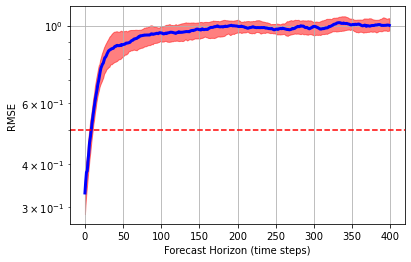

It takes around t = 0.09 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.738
Median NRMSE at t = 0.5: 0.882
Median NRMSE at t = 1: 0.953
Median NRMSE at t = 2: 0.997
Median NRMSE at t = 3: 0.993


In [60]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 Loss coefficients

In [52]:
hidden_size = [64, 128, 128, 256]
max_lag = 16

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.3.1 Base [1, 1, 0.1, 0.01]
This is done in 3.2.3

### 3.3.2 Increased focus on forward loss [1, 2, 0.1, 0.01]

In [53]:
loss_weights = [1, 2, .1, .01]

In [54]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.11 | Train loss = 0.1999162 | Val loss =  1.4035655
Epoch 20: Time taken = 3.08 | Train loss = 0.1386221 | Val loss =  1.9274597
Epoch 30: Time taken = 3.09 | Train loss = 0.1100107 | Val loss =  1.9467495
EARLY STOPPING. Epoch 34: Train loss = 0.1010946 | Val loss =  2.0514713
Best Validation MSE: 0.9896381
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.08 | Train loss = 0.1507973 | Val loss =  1.9250281
Epoch 20: Time taken = 3.12 | Train loss = 0.1164694 | Val loss =  1.9589320
Epoch 30: Time taken = 3.11 | Train loss = 0.0937047 | Val loss =  2.0247592
EARLY STOPPING. Epoch 33: Train loss = 0.0887560 | Val loss =  2.1434609
Best Validation MSE: 1.0311550

Epoch 10: Time taken = 3.07 | Train loss = 0.1310205 | Val loss =  1.8592358
Epoch 20: Time taken = 3.07 | Train loss = 0.1031518 | Val loss =  2.0211346
Epoch 30: Time taken = 3.06 | Train loss = 0.0842902 | Val loss =  2.0663212
EARLY STOPPING. Epoch 31: Train loss = 0.0825943 |

In [55]:
mean_pred = get_test_pred(X_test, params, network)

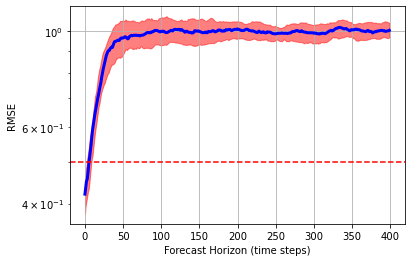

It takes around t = 0.06 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.748
Median NRMSE at t = 0.5: 0.964
Median NRMSE at t = 1: 0.999
Median NRMSE at t = 2: 1.011
Median NRMSE at t = 3: 0.988


In [56]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 Only autoencoder and forward loss [1, 1, 0, 0]

In [57]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [58]:
loss_weights = [1, 1, 0, 0]

In [59]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.80 | Train loss = 0.3383492 | Val loss =  0.9186116
Epoch 20: Time taken = 0.81 | Train loss = 0.2693157 | Val loss =  0.9177279
Epoch 30: Time taken = 0.78 | Train loss = 0.2217891 | Val loss =  0.9553909
Epoch 40: Time taken = 0.78 | Train loss = 0.1946198 | Val loss =  1.0324408
Epoch 50: Time taken = 0.81 | Train loss = 0.1840915 | Val loss =  0.9427354
Best Validation MSE: 0.9051103
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.79 | Train loss = 0.2028802 | Val loss =  1.0044289
Epoch 20: Time taken = 0.78 | Train loss = 0.1855883 | Val loss =  0.9629494
Epoch 30: Time taken = 0.78 | Train loss = 0.1777180 | Val loss =  1.0361833
EARLY STOPPING. Epoch 36: Train loss = 0.1688432 | Val loss =  0.9971651
Best Validation MSE: 0.9229761

Epoch 10: Time taken = 0.82 | Train loss = 0.1857262 | Val loss =  1.0081047
Epoch 20: Time taken = 0.78 | Train loss = 0.1765896 | Val loss =  1.0024796
Epoch 30: Time taken = 0.78 | Train loss = 0.1

In [60]:
mean_pred = get_test_pred(X_test, params, network)

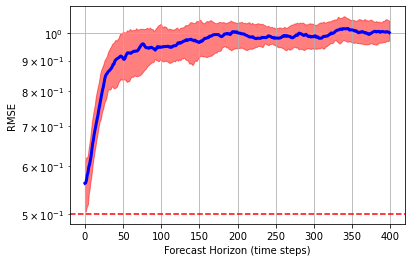

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.767
Median NRMSE at t = 0.5: 0.907
Median NRMSE at t = 1: 0.947
Median NRMSE at t = 2: 1.002
Median NRMSE at t = 3: 0.986


In [61]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.4 Equal weightage to forward and backward dynamic [1, 0.5, 0.5, 0.01]

In [62]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [63]:
loss_weights = [1, 0.5, 0.5, 0.01]

In [64]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 1.07 | Train loss = 0.3790157 | Val loss =  0.9495347
Epoch 20: Time taken = 1.01 | Train loss = 0.3278454 | Val loss =  1.1266452
Epoch 30: Time taken = 1.02 | Train loss = 0.2859680 | Val loss =  1.0102807
EARLY STOPPING. Epoch 38: Train loss = 0.2773988 | Val loss =  2.0203652
Best Validation MSE: 0.9408682
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.02 | Train loss = 0.3113466 | Val loss =  1.0061379
Epoch 20: Time taken = 1.00 | Train loss = 0.2795698 | Val loss =  1.7870232
Epoch 30: Time taken = 0.99 | Train loss = 0.2711227 | Val loss =  2.1958896
EARLY STOPPING. Epoch 39: Train loss = 0.2458518 | Val loss =  2.4619608
Best Validation MSE: 0.9650217

Epoch 10: Time taken = 1.25 | Train loss = 0.2747484 | Val loss =  2.0370592
Epoch 20: Time taken = 1.19 | Train loss = 0.2544209 | Val loss =  2.3889415
Epoch 30: Time taken = 1.16 | Train loss = 0.2403766 | Val loss =  2.5875777
EARLY STOPPING. Epoch 32: Train loss = 0.2392777 |

In [65]:
mean_pred = get_test_pred(X_test, params, network)

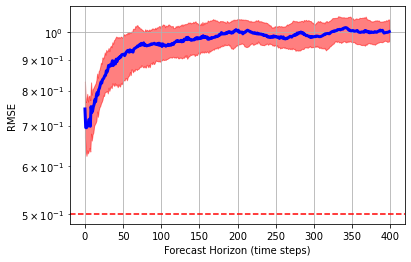

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.816
Median NRMSE at t = 0.5: 0.918
Median NRMSE at t = 1: 0.955
Median NRMSE at t = 2: 1.004
Median NRMSE at t = 3: 0.982


In [66]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.5 Increased and Equal weightage to forward and backward dynamic [1, 1, 1, 0.01]

In [67]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [68]:
loss_weights = [1, 1, 1, 0.01]

In [69]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 1.14 | Train loss = 0.6347469 | Val loss =  0.9687114
Epoch 20: Time taken = 1.14 | Train loss = 0.5596665 | Val loss =  1.6001965
Epoch 30: Time taken = 1.14 | Train loss = 0.5158715 | Val loss =  1.8382029
EARLY STOPPING. Epoch 36: Train loss = 0.5049912 | Val loss =  1.8717553
Best Validation MSE: 0.9389264
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.14 | Train loss = 0.5565941 | Val loss =  1.6429287
Epoch 20: Time taken = 1.18 | Train loss = 0.5122973 | Val loss =  1.8561519
Epoch 30: Time taken = 1.26 | Train loss = 0.4867228 | Val loss =  1.9214318
EARLY STOPPING. Epoch 32: Train loss = 0.4795259 | Val loss =  1.8820337
Best Validation MSE: 0.9536346

Epoch 10: Time taken = 1.14 | Train loss = 0.5326128 | Val loss =  1.8049009
Epoch 20: Time taken = 1.17 | Train loss = 0.5018569 | Val loss =  1.8892848
Epoch 30: Time taken = 1.14 | Train loss = 0.4689110 | Val loss =  1.6419906
EARLY STOPPING. Epoch 32: Train loss = 0.4639208 |

In [70]:
mean_pred = get_test_pred(X_test, params, network)

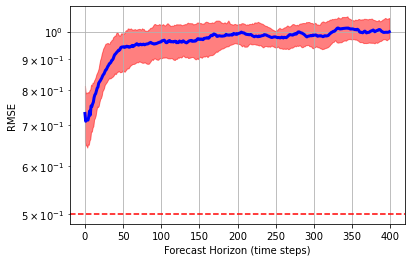

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.829
Median NRMSE at t = 0.5: 0.943
Median NRMSE at t = 1: 0.962
Median NRMSE at t = 2: 0.992
Median NRMSE at t = 3: 0.986


In [71]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Final Model

In [72]:
hidden_size = [64, 128, 128, 256]
max_lag = 16
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [73]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.06 | Train loss = 0.1055726 | Val loss =  1.0527659
Epoch 20: Time taken = 3.02 | Train loss = 0.0809304 | Val loss =  1.1238267
Epoch 30: Time taken = 3.03 | Train loss = 0.0718750 | Val loss =  2.0671025
EARLY STOPPING. Epoch 34: Train loss = 0.0682107 | Val loss =  2.1570671
Best Validation MSE: 0.9868233
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.03 | Train loss = 0.0840482 | Val loss =  1.0892374
Epoch 20: Time taken = 3.03 | Train loss = 0.0737236 | Val loss =  2.1909800
Epoch 30: Time taken = 3.03 | Train loss = 0.0637078 | Val loss =  2.0683811
EARLY STOPPING. Epoch 33: Train loss = 0.0606384 | Val loss =  2.2196061
Best Validation MSE: 0.9791381
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.05 | Train loss = 0.0783075 | Val loss =  1.3423376
Epoch 20: Time taken = 3.04 | Train loss = 0.0685677 | Val loss =  2.1334660
Epoch 30: Time taken = 3.06 | Train loss = 0.0577019 | Val loss =  2.1474670
EARLY STOPPING. Epoch 32: 

In [74]:
mean_pred = get_test_pred(X_test, params, network)

In [75]:
save_obj(params, res_folder, "best_params.pkl")

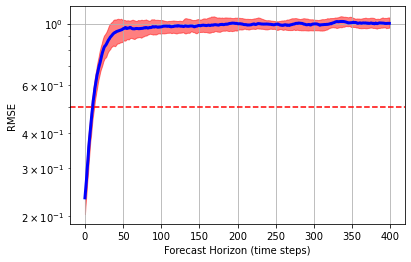

It takes around t = 0.11 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.725
Median NRMSE at t = 0.5: 0.958
Median NRMSE at t = 1: 0.973
Median NRMSE at t = 2: 1.000
Median NRMSE at t = 3: 0.997


In [76]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [13]:
res_folder = os.path.join("results", "koopman")

In [14]:
def create_network(hidden_size):
    p1, p2, p3, kappa = hidden_size
    encoder_init, encoder = stax.serial(
        Dense(p1), Tanh,  
        Dense(p2), Tanh,
        Dense(p3), Tanh,
        Dense(kappa))
    decoder_init, decoder = stax.serial(
        Dense(p3), Tanh,
        Dense(p2), Tanh,
        Dense(p1), Tanh,
        Dense(data_dim))
    forward_init, forward = stax.serial(
        Dense_no_bias(kappa))
    backward_init, backward = stax.serial(
        Dense_no_bias(kappa))
    network = (encoder, decoder, forward, backward)
    return network

In [15]:
hidden_size = [64, 128, 128, 256]

In [16]:
network = create_network(hidden_size)
params = load_obj(os.path.join(res_folder, "best_params.pkl"))

In [19]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.38


In [20]:
save_obj(mean_pred, "results", "koopman_pred.pkl")

In [21]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

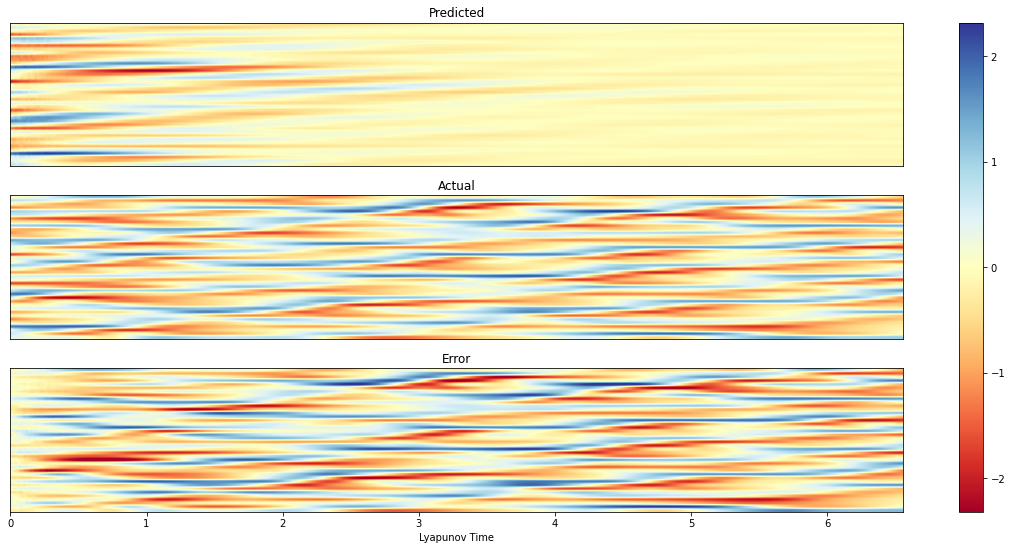

In [22]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "Lorenz_Small_Koopman")

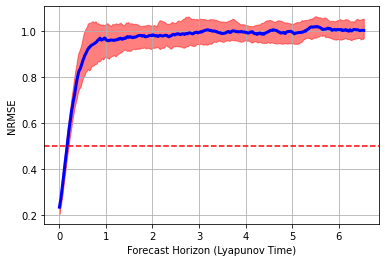

It takes around 0.18 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.865
Median NRMSE at 1.0 Lyapunov Time: 0.962
Median NRMSE at 2.0 Lyapunov Time: 0.983
Median NRMSE at 5.0 Lyapunov Time: 0.995


In [23]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Lorenz_Small_Koopman_PH")
print()
res_single.get_loss()